In [2]:
# ============================================
# PROYECTO FINAL - INTRODUCCIÓN A CIENCIA DE DATOS
# Detección de transacciones fraudulentas
# Alumno: Juan Diego Carreón Arelio
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)

sns.set(style="whitegrid")

# Cargar la base de datos limpia (generada en la unidad 2)
df = pd.read_csv("transacciones_limpias.csv")   # asegúrate que se llame así
print("Shape inicial (filas, columnas):", df.shape)
df.head()


Shape inicial (filas, columnas): (11014, 10)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,36.0,cash_out,449109.84,c630750768,14914.5,0.00,NaN,72855.780,521965.62,0.0
1,402.0,payment,8593.72,c960271657,0.0,0.00,m431752332,0.000,0.00,0.0
2,33.0,payment,9201.16,c1378359079,22962.0,13760.84,m352072570,128753.815,0.00,0.0
3,18.0,NaN,1225.30,c1707719646,0.0,0.00,m1913693032,0.000,206184.72,0.0
4,235.0,payment,9820.29,c90105308,10836.0,1015.71,m1581304819,0.000,0.00,0.0


In [3]:
# REVISIÓN INICIAL DE LA BASE LIMPIA

print("Shape final:", df.shape)

print("\nValores faltantes por columna:")
print(df.isna().sum())

print("\nPrimeras filas:")
df.head()


Shape final: (11014, 10)

Valores faltantes por columna:
step                0
type              462
amount              0
nameOrig          460
oldbalanceOrg       0
newbalanceOrig      0
nameDest          462
oldbalanceDest      0
newbalanceDest      0
isFraud             0
dtype: int64

Primeras filas:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,36.0,cash_out,449109.84,c630750768,14914.5,0.00,NaN,72855.780,521965.62,0.0
1,402.0,payment,8593.72,c960271657,0.0,0.00,m431752332,0.000,0.00,0.0
2,33.0,payment,9201.16,c1378359079,22962.0,13760.84,m352072570,128753.815,0.00,0.0
3,18.0,NaN,1225.30,c1707719646,0.0,0.00,m1913693032,0.000,206184.72,0.0
4,235.0,payment,9820.29,c90105308,10836.0,1015.71,m1581304819,0.000,0.00,0.0


In [4]:
# ============================================
# IMPUTACIÓN DE VALORES FALTANTES (MODA)
# ============================================

cat_cols = ["type", "nameOrig", "nameDest"]

for col in cat_cols:
    if df[col].isna().sum() > 0:
        moda = df[col].mode()[0]
        df[col] = df[col].fillna(moda)
        print(f"Imputación aplicada en '{col}': moda = {moda}")

print("\nValores faltantes después de imputación:")
print(df.isna().sum())



Imputación aplicada en 'type': moda = payment
Imputación aplicada en 'nameOrig': moda = c4arr$
Imputación aplicada en 'nameDest': moda = c4arr$

Valores faltantes después de imputación:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64


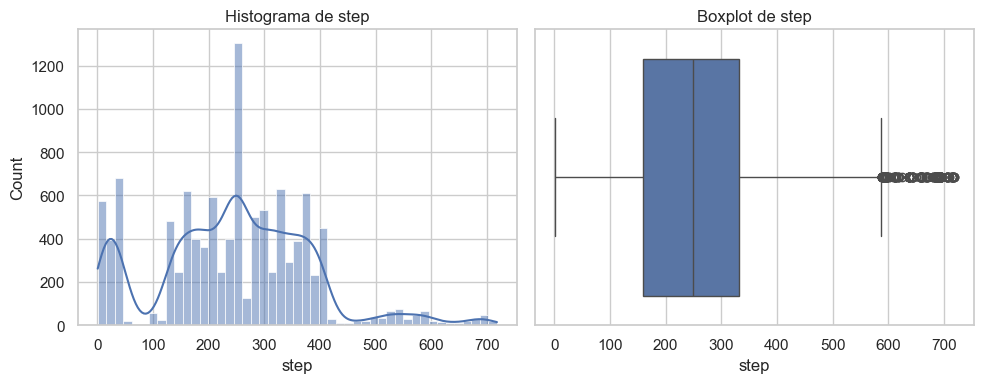

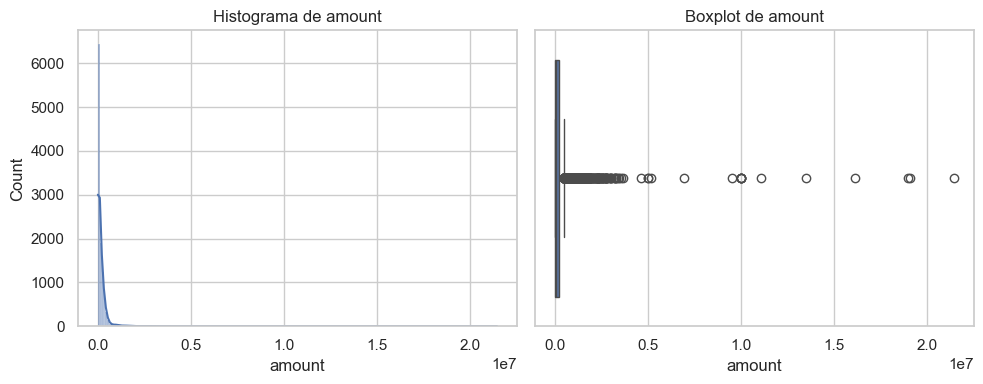

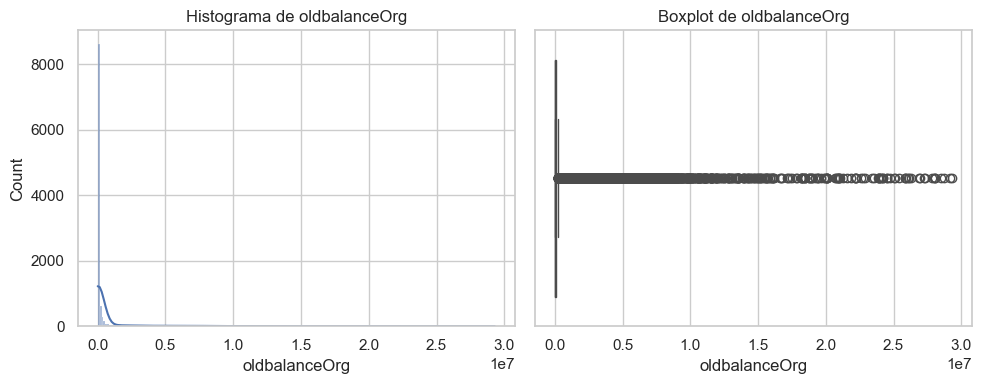

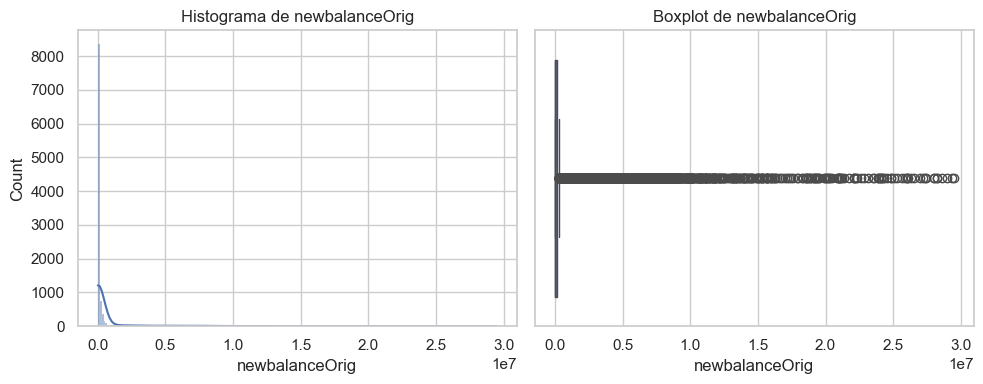

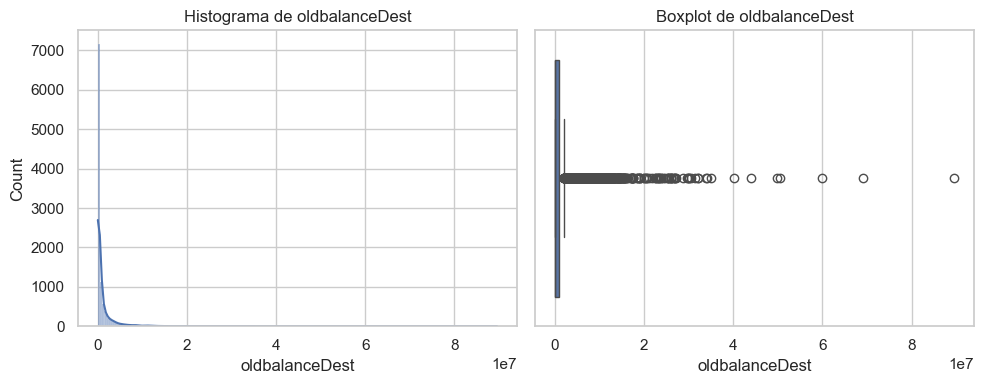

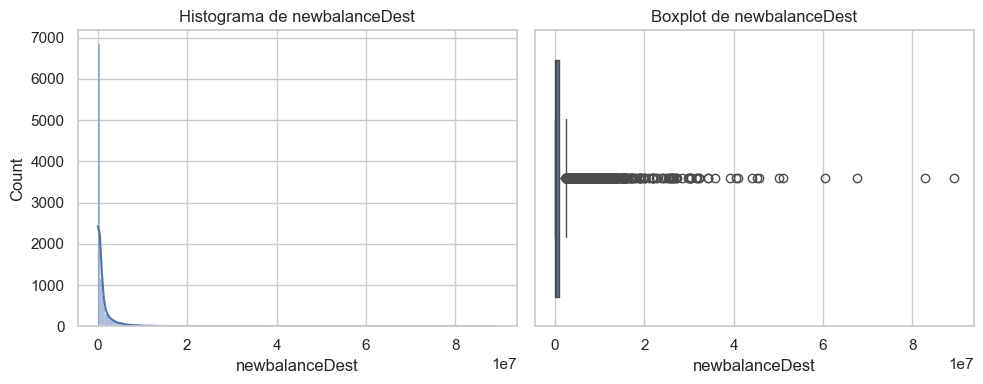

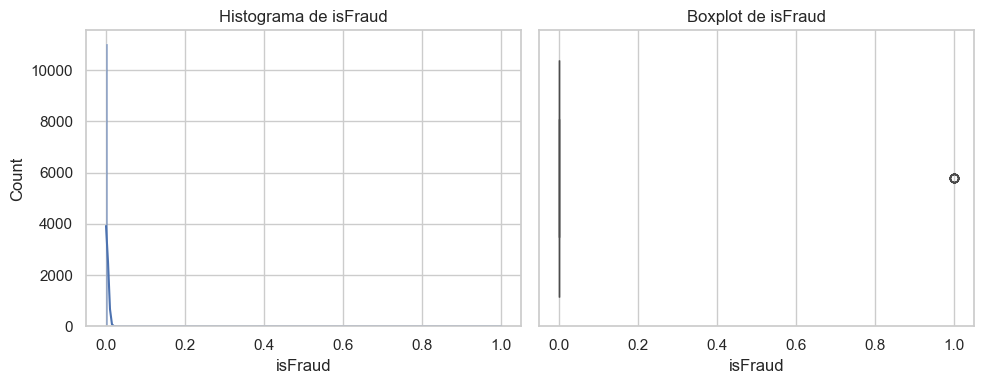

In [5]:
# ============================================
# 3. DISTRIBUCIÓN DE VARIABLES NUMÉRICAS
# Histogramas + Boxplots
# ============================================

cols_num = ["step", "amount", "oldbalanceOrg", "newbalanceOrig",
            "oldbalanceDest", "newbalanceDest", "isFraud"]

for col in cols_num:
    if col in df.columns:
        plt.figure(figsize=(10,4))

        # Histograma
        plt.subplot(1,2,1)
        sns.histplot(df[col], kde=True)
        plt.title(f"Histograma de {col}")

        # Boxplot
        plt.subplot(1,2,2)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot de {col}")

        plt.tight_layout()
        plt.show()


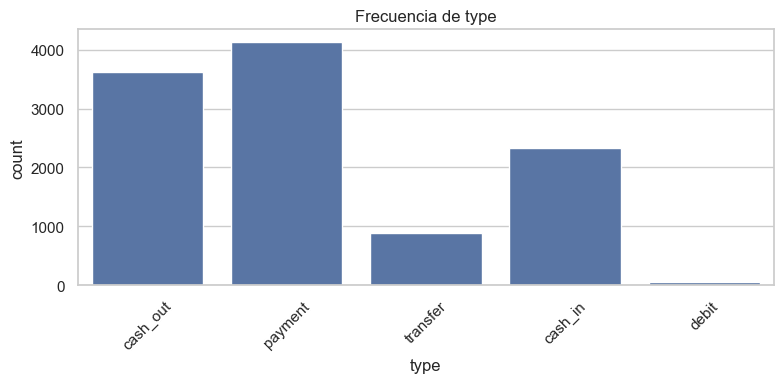

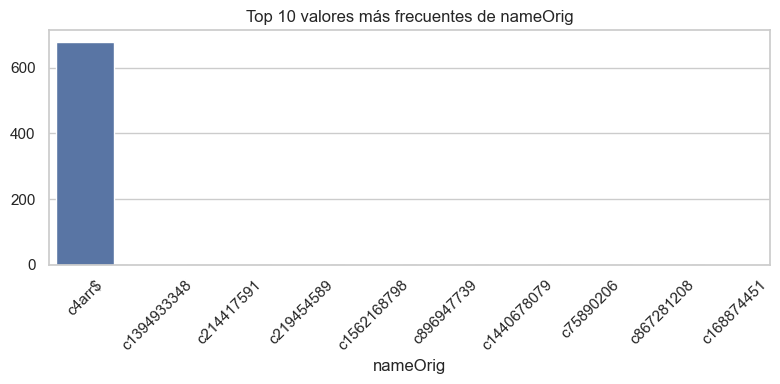

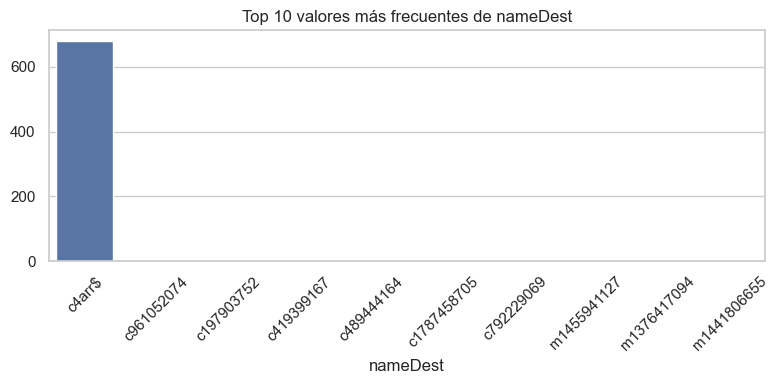

In [6]:
# ============================================
# 4. DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS
# ============================================

cols_cat = ["type", "nameOrig", "nameDest"]

for col in cols_cat:
    plt.figure(figsize=(8,4))
    # Para nameOrig y nameDest mostramos solo los top 10 más frecuentes
    if col in ["nameOrig", "nameDest"]:
        top10 = df[col].value_counts().head(10)
        sns.barplot(x=top10.index, y=top10.values)
        plt.title(f"Top 10 valores más frecuentes de {col}")
        plt.xticks(rotation=45)
    else:
        sns.countplot(x=df[col])
        plt.title(f"Frecuencia de {col}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


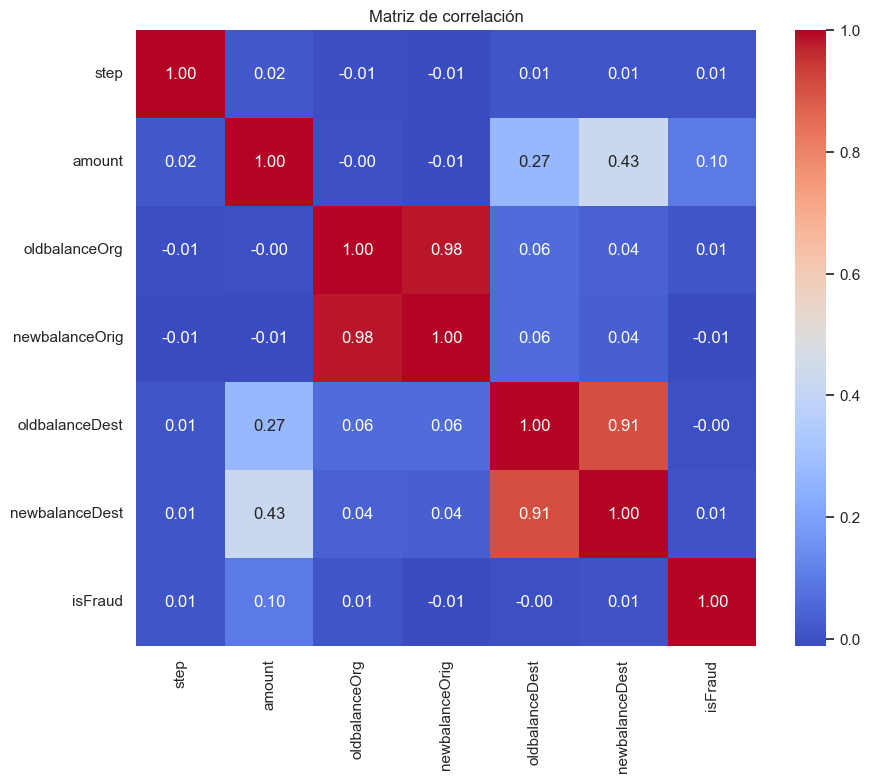

In [7]:
# ============================================
# 5. MATRIZ DE CORRELACIÓN
# ============================================

plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()


In [8]:
# ============================================
# 6. DETECCIÓN DE OUTLIERS (IQR)
# ============================================

def detectar_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
    print(f"{col}: {len(outliers)} outliers encontrados")
    return outliers

cols_num = ["step", "amount", "oldbalanceOrg", "newbalanceOrig",
            "oldbalanceDest", "newbalanceDest"]

for col in cols_num:
    detectar_outliers(col)


step: 225 outliers encontrados
amount: 599 outliers encontrados
oldbalanceOrg: 1861 outliers encontrados
newbalanceOrig: 1767 outliers encontrados
oldbalanceDest: 1473 outliers encontrados
newbalanceDest: 1367 outliers encontrados


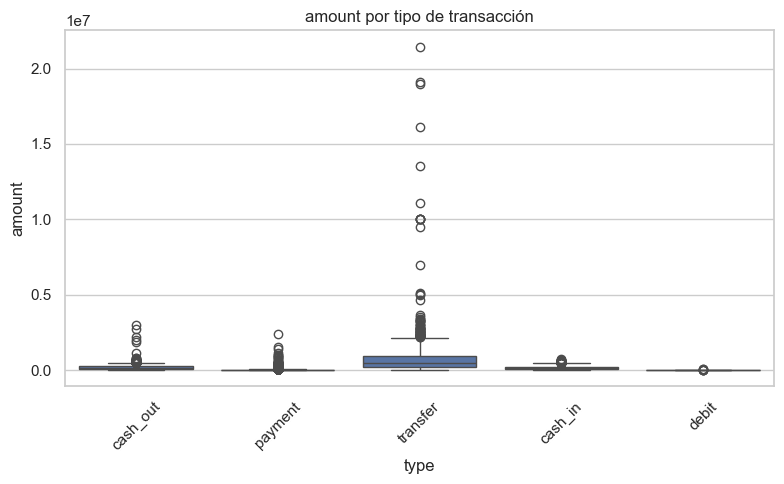

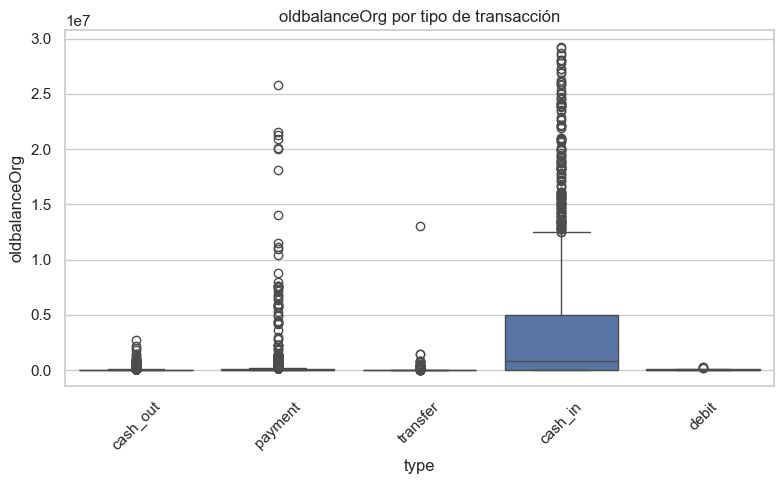

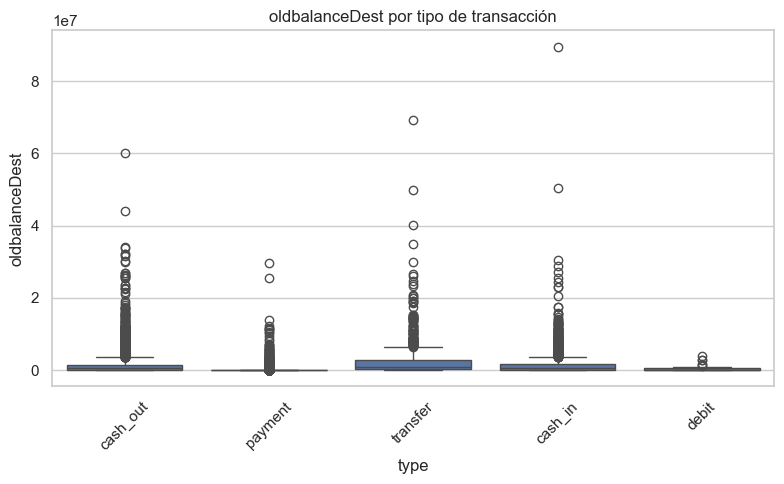

In [9]:
# ============================================
# 7. RELACIÓN ENTRE VARIABLES CATEGÓRICAS Y NUMÉRICAS
# ============================================

cols_num_rel = ["amount", "oldbalanceOrg", "oldbalanceDest"]

for col in cols_num_rel:
    plt.figure(figsize=(8,5))
    sns.boxplot(x="type", y=col, data=df)
    plt.title(f"{col} por tipo de transacción")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Conteo de clases:
isFraud
0.0    11001
1.0       13
Name: count, dtype: int64

Proporción de clases:
isFraud
0.0    0.99882
1.0    0.00118
Name: proportion, dtype: float64


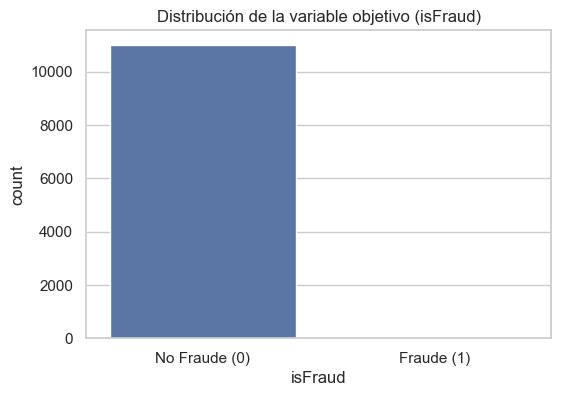

In [10]:
# ============================================
# 8. ANÁLISIS DE LA VARIABLE isFraud
# ============================================

print("Conteo de clases:")
print(df["isFraud"].value_counts())

print("\nProporción de clases:")
print(df["isFraud"].value_counts(normalize=True))

plt.figure(figsize=(6,4))
sns.countplot(x="isFraud", data=df)
plt.title("Distribución de la variable objetivo (isFraud)")
plt.xticks([0,1], ["No Fraude (0)", "Fraude (1)"])
plt.show()


In [11]:
# ============================================
# 9. PREPARACIÓN DE DATOS PARA ML
# ============================================

# Eliminamos columnas que no aportan valor
df_model = df.drop(["nameOrig", "nameDest"], axis=1)

# One hot encoding para las categóricas
df_model = pd.get_dummies(df_model, columns=["type"], drop_first=True)

print("Columnas finales del modelo:")
print(df_model.columns)

# Variables predictoras y objetivo
X = df_model.drop("isFraud", axis=1)
y = df_model["isFraud"]

print("\nShape de X:", X.shape)
print("Shape de y:", y.shape)


Columnas finales del modelo:
Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'type_cash_out', 'type_debit',
       'type_payment', 'type_transfer'],
      dtype='object')

Shape de X: (11014, 10)
Shape de y: (11014,)


In [12]:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
 'newbalanceDest', 'type_cash_out', 'type_debit',
 'type_payment', 'type_transfer']


['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'type_cash_out',
 'type_debit',
 'type_payment',
 'type_transfer']

Accuracy: 0.9981842941443486
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2200
         1.0       0.00      0.00      0.00         3

    accuracy                           1.00      2203
   macro avg       0.50      0.50      0.50      2203
weighted avg       1.00      1.00      1.00      2203



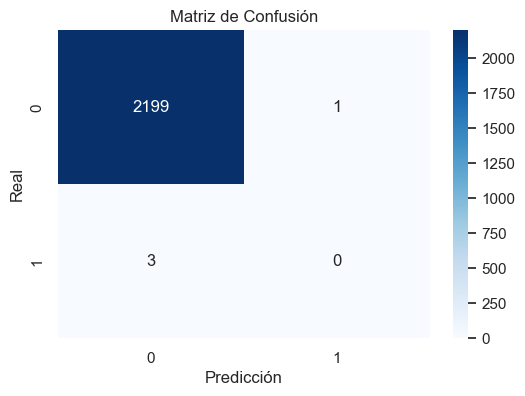

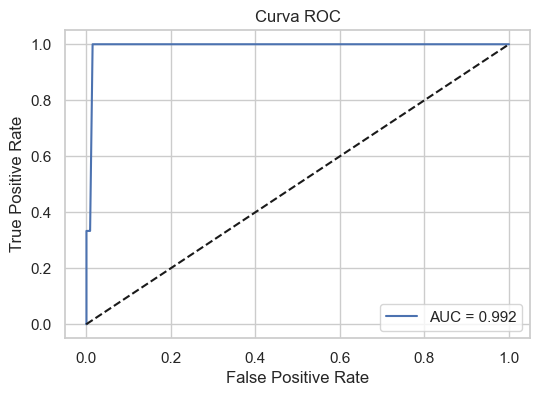

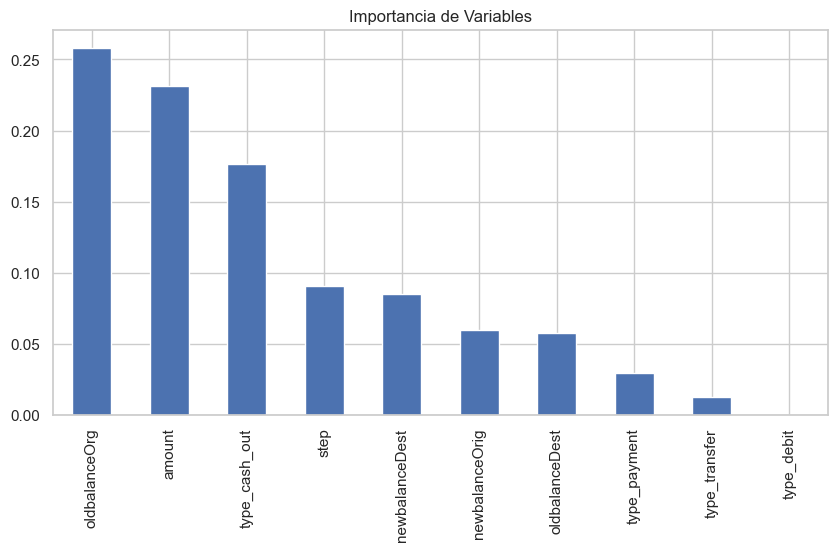

In [13]:
# ============================================
# 10. DIVISIÓN DE DATOS Y ENTRENAMIENTO
# ============================================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Modelo
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"   # IMPORTANTE por el desbalanceo
)

# Entrenar
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# ============================================
# 11. MÉTRICAS
# ============================================

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1-Score:", f1_score(y_test, y_pred, zero_division=0))

print("\nREPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_pred, zero_division=0))

# ============================================
# 12. MATRIZ DE CONFUSIÓN
# ============================================

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# ============================================
# 13. CURVA ROC
# ============================================

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

# ============================================
# 14. IMPORTANCIA DE VARIABLES
# ============================================

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Importancia de Variables")
plt.show()


In [14]:
# ============================================
# MODELO 2: BALANCEO SENCILLO POR OVERSAMPLING
# ============================================

# Partimos del df_model que ya tenías (sin nameOrig/nameDest y con dummies en type)

fraudes = df_model[df_model["isFraud"] == 1]
no_fraudes = df_model[df_model["isFraud"] == 0]

print("Fraudes originales:", len(fraudes))
print("No fraudes originales:", len(no_fraudes))

# Oversampling: duplicamos fraudes hasta tener 1000
fraudes_oversampled = fraudes.sample(n=1000, replace=True, random_state=42)

# Unimos no_fraudes + fraudes_oversampled
df_bal = pd.concat([no_fraudes, fraudes_oversampled], axis=0)
df_bal = df_bal.sample(frac=1, random_state=42).reset_index(drop=True)  # mezclamos

print("\nShape del dataframe balanceado:", df_bal.shape)
print(df_bal["isFraud"].value_counts())


Fraudes originales: 13
No fraudes originales: 11001

Shape del dataframe balanceado: (12001, 11)
isFraud
0.0    11001
1.0     1000
Name: count, dtype: int64


In [15]:
# Variables para el modelo balanceado

X_bal = df_bal.drop("isFraud", axis=1)
y_bal = df_bal["isFraud"]

print("Shape X_bal:", X_bal.shape)
print("Shape y_bal:", y_bal.shape)


Shape X_bal: (12001, 10)
Shape y_bal: (12001,)


Accuracy (balanceado): 1.0
Precision (balanceado): 1.0
Recall (balanceado): 1.0
F1-Score (balanceado): 1.0

REPORTE DE CLASIFICACIÓN (balanceado):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2201
         1.0       1.00      1.00      1.00       200

    accuracy                           1.00      2401
   macro avg       1.00      1.00      1.00      2401
weighted avg       1.00      1.00      1.00      2401



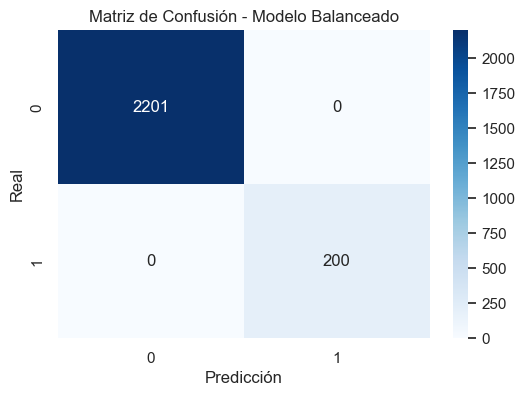

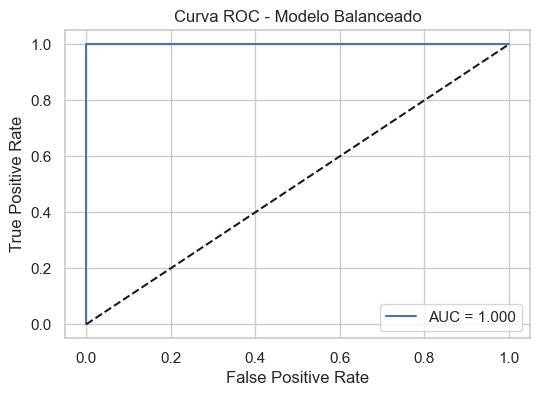

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# Train / test con datos balanceados
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

model_bal = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

model_bal.fit(X_train_b, y_train_b)

y_pred_b = model_bal.predict(X_test_b)
y_proba_b = model_bal.predict_proba(X_test_b)[:,1]

print("Accuracy (balanceado):", accuracy_score(y_test_b, y_pred_b))
print("Precision (balanceado):", precision_score(y_test_b, y_pred_b, zero_division=0))
print("Recall (balanceado):", recall_score(y_test_b, y_pred_b, zero_division=0))
print("F1-Score (balanceado):", f1_score(y_test_b, y_pred_b, zero_division=0))

print("\nREPORTE DE CLASIFICACIÓN (balanceado):")
print(classification_report(y_test_b, y_pred_b, zero_division=0))

# Matriz de confusión
cm_b = confusion_matrix(y_test_b, y_pred_b)

plt.figure(figsize=(6,4))
sns.heatmap(cm_b, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Modelo Balanceado")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr_b, tpr_b, _ = roc_curve(y_test_b, y_proba_b)
roc_auc_b = auc(fpr_b, tpr_b)

plt.figure(figsize=(6,4))
plt.plot(fpr_b, tpr_b, label=f"AUC = {roc_auc_b:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Modelo Balanceado")
plt.legend()
plt.show()


In [17]:
df.to_csv("transacciones_limpias_final.csv", index=False)
print("Archivo guardado: transacciones_limpias_final.csv")

Archivo guardado: transacciones_limpias_final.csv
